In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from TPTBox import NII
import json
import os
import numpy as np
import torch
from matplotlib.colors import ListedColormap
from typing import Literal

## Load Data

In [3]:
project_folder = "/vol/miltank/projects/practical_WS2425/diffusion/"
img_nii_dir = project_folder + "data/amos22/"
seg_nii_dir = project_folder + "data/amos_robert/"
seg_nii_dir = project_folder + "data/amos22/"
with open(project_folder + "data/amos22/dataset.json") as f:
    info = json.load(f)
info.keys()

dict_keys(['name', 'description', 'author', 'reference', 'licence', 'release', 'contact', 'tensorImageSize', 'modality', 'labels', 'numTraining', 'numValidation', 'numTest', 'training', 'validation', 'test'])

In [4]:
info['labels']

{'0': 'background',
 '1': 'spleen',
 '2': 'right kidney',
 '3': 'left kidney',
 '4': 'gall bladder',
 '5': 'esophagus',
 '6': 'liver',
 '7': 'stomach',
 '8': 'arota',
 '9': 'postcava',
 '10': 'pancreas',
 '11': 'right adrenal gland',
 '12': 'left adrenal gland',
 '13': 'duodenum',
 '14': 'bladder',
 '15': 'prostate/uterus'}

In [5]:
labels_dict = {
 '0': 'background, Hintergrund',
 '1': 'spleen, Milz',
 '2': 'right kidney, rechte Niere',
 '3': 'left kidney, linke Niere',
 '4': 'gall bladder, Gallenblase',
 '5': 'esophagus, Speiseröhre',
 '6': 'liver, Leber',
 '7': 'stomach, Magen',
 '8': 'arota, Aorta',
 '9': 'postcava, Hohlvene',
 '10': 'pancreas, Bauchspeicheldrüse',
 '11': 'right adrenal gland, rechte Nebenniere',
 '12': 'left adrenal gland, linke Nebenniere',
 '13': 'duodenum, Zwölffingerdarm',
 '14': 'bladder, Blase',
 '15': 'prostate/uterus, Prostata/Gebärmutter'
}

In [6]:
labels_dict = json.loads(open("label_info.json").read())["german"]

In [71]:
# nii_idx = 549
# split="Va"
# slice_idx=100
# slice_direction = 'axial'

nii_idx = 1
split="Tr"
slice_idx=100
slice_axis = 'axial'

nii_idx = 598
split="Va"

# mrt
nii_idx = 510
split = "Tr"

###############################
# NAMING
# axial:    top   - bottom = superior - inferior
# coronal:  front - back   = anterior - posterior
# sagittal: left  - right  = left     - right
############################## 
# orient so that with origin in top left image corner:
# top - bottom = anterior - posterior
# top - bottom = superior - inferior
# left - right = left - right
# left - right = anterior - posterior
##############################
# resulting indexing
# top down
# front back
# left right
##############################

image_path = img_nii_dir + '/images' + split + '/amos_' + str(nii_idx).zfill(4) + '.nii.gz'
label_path = seg_nii_dir + '/labels' + split + '/amos_' + str(nii_idx).zfill(4) + '.nii.gz'

img = NII.load(image_path, seg=False)
seg = NII.load(label_path, seg=True)

# img.rescale_and_reorient(("I", "P", "R"), (1,1,1), inplace=True)
# seg.rescale_and_reorient(("I", "P", "R"), (1,1,1), inplace=True)

img_np = img.get_array()
seg_np = seg.get_array()

### Get weights for labels classes

In [72]:
l, c = np.unique(seg_np, return_counts=True)
c = 1/c
c = c / c.max()
l, c

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       dtype=uint8),
 array([4.59261238e-05, 5.13966799e-03, 6.85100488e-03, 6.60530986e-03,
        2.14065465e-02, 6.06416933e-02, 9.64049757e-04, 4.47824145e-03,
        5.40297837e-03, 2.10704488e-02, 9.99142011e-03, 1.00000000e+00,
        2.10987726e-01, 2.45177941e-02]))

In [73]:
"min", np.min(img_np), "max", np.max(img_np), img_np.shape, img_np.dtype

('min', 0, 'max', 1370, (260, 104, 320), dtype('<i2'))

In [65]:
CT_IDX_RANGE = range(0, 500)
CLIPPING_RANGE = (-256, 256)
SCALE_LABELS = False
def get_slice(np_array, axis, idx):
    if axis == "axial":
        return np_array[idx, :, :]
    elif axis == "coronal":
        return np_array[:, idx, :]
    elif axis == "sagittal":
        return np_array[:, :, idx]
    
def safe_normalize(array, new_min=0, new_max=1):
    if array.max() == array.min():
        return array
    return (array - array.min()) / (array.max() - array.min()) * (
        new_max - new_min
    ) + new_min


def normalize_nii(nii_np, file_name, is_seg):
    if not is_seg:
        is_ct = int(file_name.split("_")[-1].split(".")[0]) in CT_IDX_RANGE
        if is_ct:
            # clip only if is CT
            print("is ct")
            nii_np = np.clip(nii_np, CLIPPING_RANGE[0], CLIPPING_RANGE[1])
        nii_np = safe_normalize(nii_np, 0, 255)
    if is_seg and SCALE_LABELS:
        nii_np = safe_normalize(nii_np, 0, 255)
    return nii_np

In [66]:
np.where(img_np == 0)

(array([  0,   0,   0, ..., 259, 259, 259]),
 array([  0,   0,   0, ..., 103, 103, 103]),
 array([  0,   1,   2, ..., 317, 318, 319]))

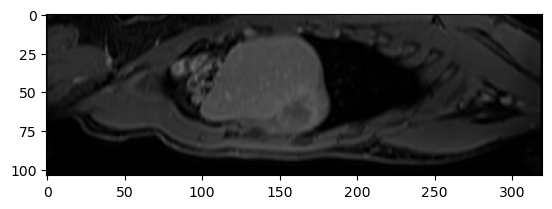

In [83]:
img_test = img_np.copy()
img_test = normalize_nii(img_test, image_path, is_seg=False)
sl = get_slice(img_test, slice_axis, 211)
plt.imshow(sl, cmap="gray", vmin=0, vmax=255)
# plt.imshow(sl, cmap="gray")

In [76]:
img_np.min(), img_np.max()

(0, 1370)

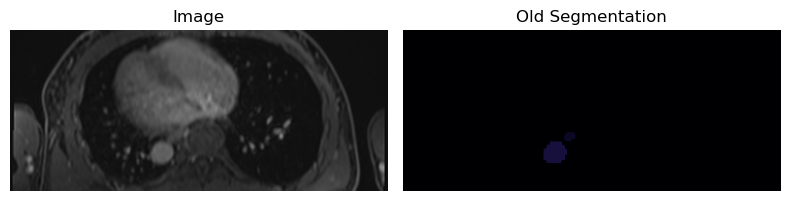

In [13]:
# slice_idx=350 # unten
slice_idx=150 # oben
slice_axis = 'axial'

# slice_idx=220 # vorn
# slice_idx=280 # hinten
# slice_axis = 'coronal'

# slice_idx=250 # rechts
# slice_idx=130 # links
# slice_axis = 'sagittal'

img_slice = get_slice(img_np, slice_axis, slice_idx)
seg_slice = get_slice(seg_np, slice_axis, slice_idx)
    
img_slice = np.clip(img_slice, -256, 256)

# img_slice = (img_slice + np.abs(img_slice.min())) / (img_slice.max() - img_slice.min())

# img_pil = Image.fromarray((img_slice * 255).astype(np.uint8), 'L')
# seg_pil = Image.fromarray(seg_slice.astype(np.uint8), 'L')

# Create segmentation colors (tab20 colormap for 16 classes)
colors = plt.cm.tab20(np.linspace(0, 1, len(labels_dict)))
# cmap = ListedColormap(colors[:len(labels_dict)])

# Plotting
plt.figure(figsize=(8, 4))
# img
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap="gray", vmin=0, vmax=255)
plt.title("Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(seg_slice, cmap="magma", vmin=0, vmax=len(labels_dict)-1)
plt.title("Old Segmentation")
plt.axis("off")

# Create the legend
# handles = [
#     plt.Line2D([0], [0], color=colors[i % len(colors)], lw=4, label=idx + " " + label) 
#     for i, (idx, label) in enumerate(labels_dict.items())
# ]
# plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", title="Classes")

plt.tight_layout()
plt.show()

### Test Clamp Values

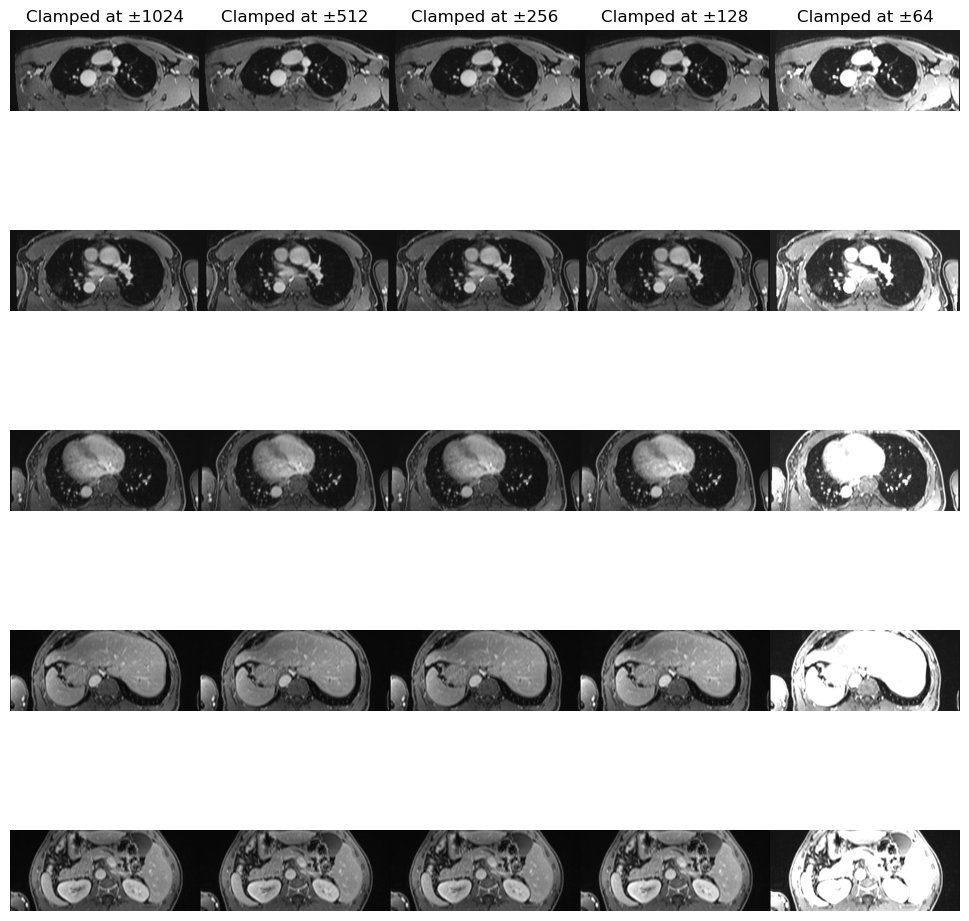

In [14]:
clamp_values = [1024, 512, 256, 128, 64]
slice_indices = [50, 100, 150, 200, 250]

fig, axes = plt.subplots(len(slice_indices), len(clamp_values), figsize=(9.5, 10))

for j, slice_idx in enumerate(slice_indices):
    img_slice = get_slice(img_np, slice_axis, slice_idx)
    
    for i, clamp in enumerate(clamp_values):
        clamped_img_slice = np.clip(img_slice, -clamp, clamp)
        ax = axes[j, i]
        ax.imshow(clamped_img_slice, cmap="gray")
        
        # Only label the first image in each row and column
        if j == 0:
            ax.set_title(f"Clamped at ±{clamp}")
        ax.axis("off")
        if i == 0:
            ax.set_ylabel(f"Slice {slice_idx}")
        
        ax.yaxis.set_ticks([])

plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

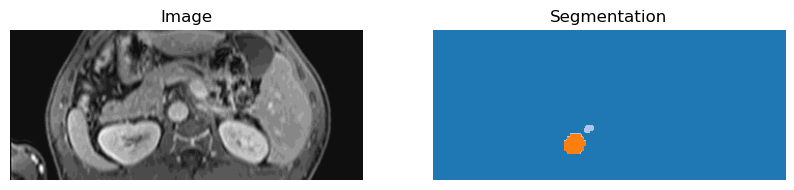

In [15]:
#save image
test_img = Image.fromarray(((img_slice + 1024) / 2048 * 255).astype(np.uint8), 'L')
test_seg = Image.fromarray(seg_slice.astype(np.uint8), 'L')

test_img.save("img.png")
test_seg.save("seg.png")

# load image
test_img = np.array(Image.open("img.png"))
test_seg = np.array(Image.open("seg.png"))

# show with plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img, cmap="gray")
plt.title("Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(test_seg, cmap="tab20", vmin=0, vmax=len(labels_dict)-1)
plt.title("Segmentation")
plt.axis("off")
plt.show()

### Compare roberts dataset

In [ ]:
a = '/vol/miltank/projects/practical_WS2425/diffusion/data/amos_robert_slices/labelsTr'
b = '/vol/miltank/projects/practical_WS2425/diffusion/data/amos_slices/labelsTr'
afiles = set(os.listdir(a))
bfiles = set(os.listdir(b))
adiff = afiles - bfiles
bdiff = bfiles - afiles
bdiff = list(bdiff)
bdiff.sort()
bdiff[:5]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]


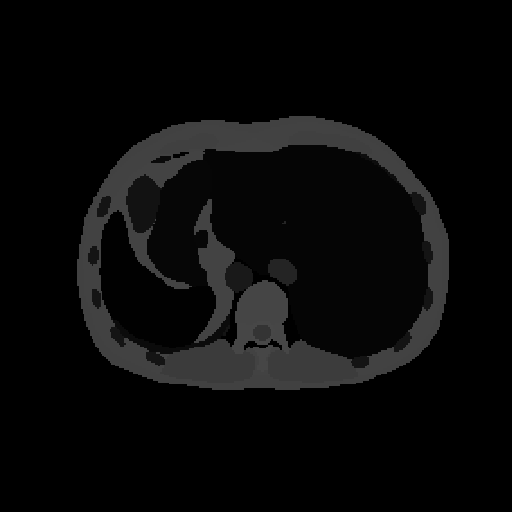

In [17]:
test_nii = "/vol/miltank/projects/practical_WS2425/diffusion/data/amos_robert/labelsTr/amos_0009.nii.gz"
s = NII.load(test_nii, seg=True)
s = s.reorient(axcodes_to=("I", "P", "R"))
s_np = s.get_array()
print(np.unique(s_np))
s_pil = Image.fromarray(s_np[50, :, :].astype(np.uint8), 'L')
s_pil

In [18]:
l, c = np.unique(s, return_counts=True)
c = 1/c
c = (c / c.max()) * 2
l, c
c = np.clip(c.round(4), 0.0001, 1)
print(c)
np.save("label_weights.npy", c)

[1.000e-04 4.000e-04 1.000e-03 8.000e-04 8.000e-03 1.000e-04 9.000e-04
 1.400e-03 7.580e-02 3.630e-02 1.000e-04 2.000e-04 2.000e-04 4.000e-04
 1.000e-04 3.400e-03 3.600e-03 1.510e-02 2.000e-04 3.500e-03 3.000e-04
 3.800e-03 3.000e-04 7.000e-04 4.700e-03 2.810e-02 1.100e-02 2.000e-02
 3.610e-02 2.320e-02 9.100e-03 2.690e-02 3.060e-02 9.100e-03 1.800e-03
 5.400e-03 2.040e-02 1.730e-02 1.170e-02 1.990e-02 3.000e-03 2.400e-03
 1.500e-03 1.400e-03 5.300e-03 4.500e-03 1.900e-03 1.900e-03 1.700e-03
 1.235e-01 5.850e-02 2.500e-03 2.600e-03 3.448e-01 5.208e-01 2.000e-04
 2.000e-04 8.000e-04 8.000e-04 2.400e-03 8.000e-04 1.000e-04 1.000e-04
 2.000e-04 1.500e-03 5.000e-04 7.000e-04 5.000e-03 1.000e+00]
